In [1]:
import networkx as nx  
import matplotlib.pyplot as plt  
import numpy as np  

In [148]:
import utils as ut
# ut.set_random_seed(123)

def data_pre(n, d, s0, w_graph_type, p_graph_type, sem_type, num_step=5):

    w_true = ut.simulate_dag(d, s0, w_graph_type)
    w_mat = ut.simulate_parameter(w_true)


    adj1 = ut.generate_adj(n)

    # num_step = 5
    Xbase = []

    Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)
    p1_mat, p1_true = ut.generate_tri(d, p_graph_type, low_value=0.0, high_value=2)
 
    for i in range(num_step):
        Xbase1 = ut.simulate_linear_sem_with_P(w_mat, p1_mat, adj1@Xbase1, n, sem_type, noise_scale=1)
        Xbase.append(Xbase1)

    return Xbase, adj1, w_true,w_mat, p1_true, p1_mat

n = 100
d = 2

w_graph_type = 'BA'
p_graph_type = 'SBM'
sem_type = 'exp'
s0 = 1 * d
num_step=50
Xlags, adj1, w_true,w_mat, p1_true, p1_mat = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type, num_step=num_step)
print(Xlags[0].shape, adj1.shape, w_true.shape, p1_true.shape)

p1_true

p1_mat [[ 0.         -0.64332724]
 [ 0.72687091  0.        ]]
(100, 2) (100, 100) (2, 2) (2, 2)


array([[0, 1],
       [1, 0]])

In [118]:
# Xlags

In [149]:
# lags = 5
# X = np.array(Xlags).reshape(lags,n*d)
# Xlags, X
# X = np.array(Xlags)[:,:,0]#.reshape(lags,n)
X = np.array(Xlags)[:,0,:]
X.shape

(50, 2)

In [133]:
from dagma import utils
from dagma.linear import DagmaLinear

# adj matrix estimation
# lags = 5
X = np.array(Xlags)[:,:,0]#.reshape(lags,n*d)

model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
adj_est = model.fit(X, lambda1=0.02, w_threshold=0.05) # fit the model with L1 reg. (coeff. 0.02)


  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 180000/180000.0 [02:12<00:00, 1356.27it/s]


In [134]:
# adj1, adj_est

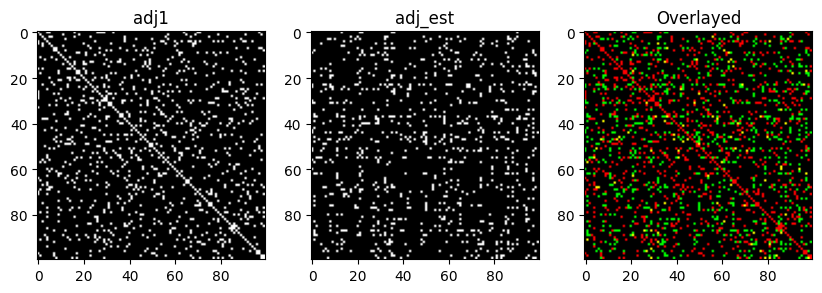

In [135]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow((adj1!=0).astype(np.uint8), cmap='gray')
axs[0].set_title('adj1')

axs[1].imshow((adj_est!=0), cmap='gray')
axs[1].set_title('adj_est')

overlay_image = np.zeros((adj1.shape[0], adj1.shape[1], 3), dtype=np.uint8)
overlay_image[..., 0] = (adj1!=0) * 255  # Red channel
overlay_image[..., 1] = (adj_est!=0) * 255   # Green channel

axs[2].imshow(overlay_image)
axs[2].set_title('Overlayed')

plt.show()

In [164]:
from dagma import utils
# from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

# P matrix estimation
X = np.array(Xlags)[:,2,:]#.reshape(lags,n*d)

eq_model = DagmaMLP(dims=[d, 5, 1], bias=True)
model = DagmaNonlinear(eq_model) 
p1_est = model.fit(X, lambda1=0.02, lambda2=0.005)

p1_true, p1_est


100%|██████████| 230000/230000.0 [07:20<00:00, 521.87it/s]


(array([[0, 1],
        [1, 0]]),
 array([[0.       , 1.2897761],
        [0.       , 0.       ]]))

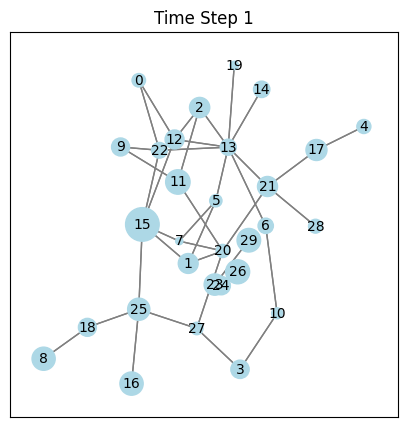

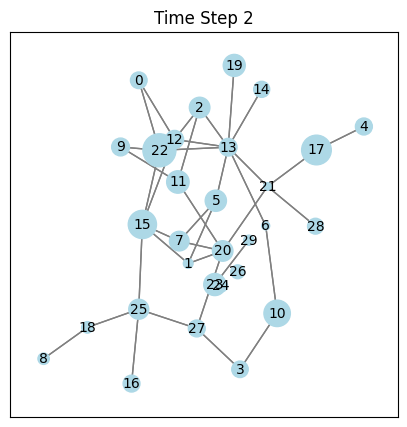

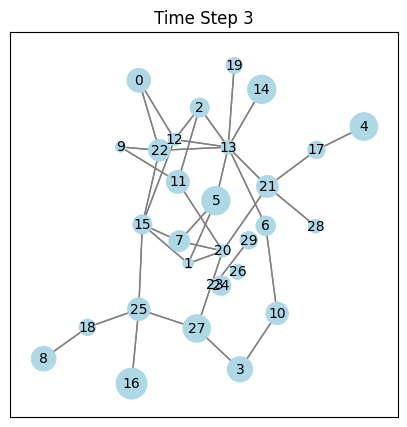

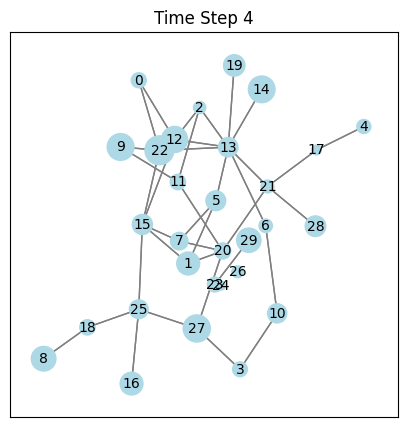

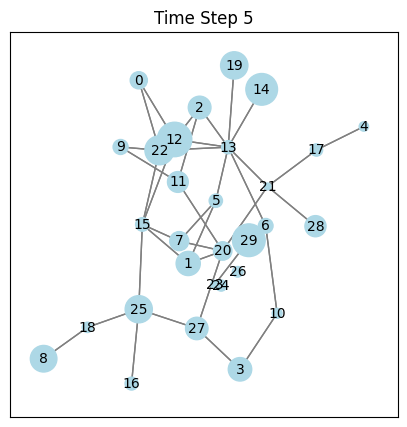

In [94]:
# Create a new figure for each time step  
for i in range(len(Xlags)):
    X = Xlags[i]
    # Calculate the norms of each row
    norms = np.linalg.norm(X, axis=1)  
    fig, ax = plt.subplots(figsize=(5, 5))  
    
    # Create a new graph for each time step  
    G = nx.DiGraph()  
    
    # Add nodes to the graph  
    G.add_nodes_from(range(n))  
    
    # Add edges to the graph based on the adjacency matrix  
    for j in range(n):  
        for k in range(n):  
            if adj1[j, k] != 0 and  j!=k:  
                G.add_edge(j, k)  
    
    # Position the nodes in a circular layout  
    # pos = nx.circular_layout(G)  
    # pos = nx.spectral_layout(G)  
    # pos = nx.community_layout(G) 
    pos = nx.kamada_kawai_layout(G)

    # Draw the nodes  
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=norms*100, node_color='lightblue')  
    
    # Draw the edges  
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', arrows=False)#, arrowsize=20)  
    
    # Draw the node labels  
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)  
    
    # Set the title of the plot  
    ax.set_title(f'Time Step {i+1}')  
    
    # Show the plot  
    plt.show()  
    # break

In [46]:
import plotly.graph_objects as go  

# Create a new figure for each time step  
for i in range(len(Xlags)):  
    fig = go.Figure(data=[go.Scatter(  
        x=[pos[j][0] for j in range(n)],  
        y=[pos[j][1] for j in range(n)],  
        mode='markers',  
        hoverinfo='text',  
        hovertext=[f'Node {j}' for j in range(n)],  
        marker=dict(size=10)  
    )])  

    # Add edges to the graph  
    for j in range(n):  
        for k in range(n):  
            if adj1[j, k] != 0 and j!=k:  
                fig.add_annotation(  
                    x=pos[j][0],  
                    y=pos[j][1],  
                    ax=pos[k][0],  
                    ay=pos[k][1],  
                    xref='x',  
                    yref='y',  
                    axref='x',  
                    ayref='y',  
                    showarrow=True,  
                    arrowhead=3,  
                    arrowsize=1,  
                    arrowwidth=1,  
                    opacity=0.5  
                )  

    # Set the title of the plot  
    fig.update_layout(title=f'Time Step {i+1}')  

    # Show the plot  
    fig.show()
    break

In [44]:
# !pip install plotly
# !pip install nbformat
# !pip install regraph
# !pip install greenery==2.0
# !pip show greenery
# !pip install neo4j

In [26]:
import regraph as rg  
import networkx as nx  
import numpy as np  

# Assuming Xlags, adj1 are the outputs from your data_pre function  
n = 20  
d = 3   

w_graph_type = 'ER'  
p_graph_type = 'SBM'  
sem_type = 'exp'  
s0 = 1 * d  
Xlags, adj1, w_true,w_mat, p1_true, p1_mat = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type)  

# Create a new figure for each time step  
for i in range(len(Xlags)):  
    # Create a new graph for each time step  
    G = nx.DiGraph()  
    
    # Add nodes to the graph  
    G.add_nodes_from(range(n))  
    
    # Add edges to the graph based on the adjacency matrix  
    for j in range(n):  
        for k in range(n):  
            if adj1[j, k] != 0 and j!=k:  
                G.add_edge(j, k)  
    
    # Create a ReGraph graph  
    graph = rg.Graph()  
    graph.add_nodes_from(G.nodes())  
    graph.add_edges_from(G.edges())  
    
    # Create a layout for the graph  
    layout = rg.spring_layout(graph)  
    
    # Create a visualization for the graph  
    visualization = rg.Visualization(graph, layout)  
    
    # Add node labels to the visualization  
    visualization.add_node_labels()  
    
    # Add edge labels to the visualization  
    visualization.add_edge_labels()  
    
    # Show the visualization  
    visualization.show()

ModuleNotFoundError: No module named 'neo4j.v1'

In [73]:
import networkx as nx  
import pyvis  
import numpy as np  

# Assuming Xlags, adj1 are the outputs from your data_pre function  
n = 20  
d = 1   

w_graph_type = 'BA'  
p_graph_type = 'SBM'  
sem_type = 'exp'  
s0 = 1 * d  
Xlags, adj1, w_true,w_mat, p1_true, p1_mat = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type)  

# Create a new figure for each time step  
for i in range(len(Xlags)):

    X = Xlags[i]  
    # Create a new graph for each time step  
    G = nx.DiGraph()  
    
    # Add nodes to the graph  
    G.add_nodes_from(range(n))  
    
    # Add edges to the graph based on the adjacency matrix  
    for j in range(n):  
        for k in range(n):  
            if adj1[j, k] != 0 and j!=k:  
                G.add_edge(j, k)  
    
    # Create a Pyvis network  
    net = pyvis.network.Network(notebook=False)  
    pos = nx.spring_layout(G)
    # Add nodes to the network  
    for node in G.nodes():  
        net.add_node(node, label=str(node), size=X[node][0]*10, x=pos[node][0]*1000, y=pos[node][1]*1000)  
    
    # Add edges to the network  
    for edge in G.edges():  
        net.add_edge(edge[0], edge[1])  
    
    # Disable physics
    net.toggle_physics(False)
    # Show the network  
    net.show('graph.html', notebook=False)
    # break

p1_mat [[0.]]
graph.html
graph.html
graph.html
graph.html
graph.html


In [67]:
for node in G.nodes():  
    print(X[node][0])

0.08864879839891691
0.11277849570478438
0.6899781564835816
1.2384865070060012
1.733566387960663
0.25356841565593424
0.5274102712044968
0.033182911511498756
0.45551997246463916
0.0113960496941753
0.49475384200809386
0.18929059701003578
2.9829108207049364
0.33865222331449985
0.8836246240580261
0.5654980602433944
1.9697204381893787
1.0891110719261283
2.641114191619631
0.8372828196071275


In [33]:
# !pip install pyvis